# Matching Clusters Across Induction and Collection

In [63]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lariat import Event
from matplotlib.patches import Rectangle

In [23]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl") # deuterons from within vertices bounding box + one track protons
print(allclusters.columns); allclusters.shape

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes'],
      dtype='object')


(438575, 27)

In [24]:
# CUTS
print(allclusters.shape)
greaterThanThree = allclusters[allclusters['height'] > 3]; print(greaterThanThree.shape) # Remove all clusters with length = 1, noise
noConstants = greaterThanThree[greaterThanThree['column_maxes'].map(lambda x: len(set(x)) > 1)]; print(noConstants.shape) # Remove all clusters where the max ADC for each wire is the same (no change in energy deposition)

(438575, 27)
(105907, 27)
(105896, 27)


In [25]:
maxes = noConstants['column_maxes'].values

normalised = []

for i, signal in enumerate(maxes):
    
    minimum = 0
    maximum = np.max(signal)

    if maximum > minimum:
        normalised_signal = (signal - minimum) / (maximum - minimum)
    else:
        normalised_signal = np.zeros_like(signal, dtype=float)
        print(f'Error: Max not greater than min in signal {i}.')

    normalised.append(normalised_signal)

noConstants['normalised'] = normalised
adcdiff = [np.diff(signal) for signal in normalised]; noConstants['adcdiff'] = adcdiff
maxdiff = [np.max(diff) for diff in adcdiff]; noConstants['maxdiff'] = maxdiff

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_52880/1492737920.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noConstants['normalised'] = normalised
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_52880/1492737920.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adcdiff = [np.diff(signal) for signal in normalised]; noConstants['adcdiff'] = adcdiff
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_52880/1492737920.py:20: SettingWithCopyWarning: 
A value is trying to

In [26]:
# CUTS
onlyPositiveDiff = noConstants[noConstants['maxdiff'] >= 0].reset_index(drop=True); print(onlyPositiveDiff.shape) # Remove all clusters with only negative change in energy deposition
lessThan180 = onlyPositiveDiff[onlyPositiveDiff['height'] < 180]; print(lessThan180.shape) # Remove all clusters wit length in wire greater than 180 - muons, noise
ADC200cut = lessThan180[lessThan180['max_intensity'] >= 200]; print(ADC200cut.shape) # Remove all clusters with max ADC less than 200, noise

(105441, 30)
(91658, 30)
(33701, 30)


In [54]:
# Bounding Box in Each Plane Cuts

collection = (
    (onlyPositiveDiff['plane'] == 'collection') &
    (onlyPositiveDiff['bbox_min_row'] > 12) & (onlyPositiveDiff['bbox_min_row'] < 37) &
    (onlyPositiveDiff['bbox_max_col'] > 789) & (onlyPositiveDiff['bbox_max_col'] < 1927)
)

# Cuts for induction plane (adjust values as needed)
induction = (
    (onlyPositiveDiff['plane'] == 'induction') &
    (onlyPositiveDiff['bbox_min_row'] > 11) & (onlyPositiveDiff['bbox_min_row'] < 35) &
    (onlyPositiveDiff['bbox_max_col'] > 786) & (onlyPositiveDiff['bbox_max_col'] < 1794)
)

# Combine both cuts
bboxCut = onlyPositiveDiff[collection | induction].reset_index(drop=True); print(bboxCut.shape)

(31607, 30)


In [55]:
events = bboxCut.groupby(['run', 'subrun', 'event']).size().reset_index(name='count')
event_counts = events['count'].value_counts()
event_counts

count
2     11836
3       815
4       718
1       529
5       197
6        87
7        39
8        18
10        8
11        4
9         3
14        1
Name: count, dtype: int64

In [56]:
grouped = bboxCut.groupby(['run', 'subrun', 'event'])
grouped = grouped.apply(lambda x: x.reset_index(drop=True))
grouped

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_52880/2125964331.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = grouped.apply(lambda x: x.reset_index(drop=True))


event_idx   run  subrun  event  \
run  subrun event                                     
8557 4      473   0        837  8557       4    473   
                  1        837  8557       4    473   
     7      596   0          0  8557       7    596   
                  1          0  8557       7    596   
     8      653   0       5493  8557       8    653   
...                        ...   ...     ...    ...   
9788 311    27203 1       3941  9788     311  27203   
                  2       3941  9788     311  27203   
                  3       3941  9788     311  27203   
            27225 0       7635  9788     311  27225   
                  1       7635  9788     311  27225   

                                                             file_path  \
run  subrun event                                                        
8557 4      473   0  /Users/user/data/research/proton-deuteron/rawd...   
                  1  /Users/user/data/research/proton-deuteron/rawd...   
     7      596   0  /Users/user/data/research/proton-deuteron/rawp...   
                  1  /Users/user/data/research/proton-deuteron/rawp...   
     8      653   0  /Users/user/data/research/proton-deuteron/rawd...   
...                                                                ...   
9788 311    27203 1  /Users/user/data/research/proton-deuteron/rawd...   
                  2  /Users/user/data/research/proton-deuteron/rawd...   
                  3  /Users/user/data/research/proton-deuteron/rawd...   
            27225 0  /Users/user/data/research/proton-deuteron/rawp...   
                  1  /Users/user/data/research/proton-deuteron/rawp...   

                     event_index particle_type       plane  cluster_idx  \
run  subrun event                                                         
8557 4      473   0            0      deuteron  collection            0   
                  1            0      deuteron   induction            0   
     7      596   0            0        proton  collection            0   
                  1            0        proton   induction            0   
     8      653   0            0      deuteron  collection            8   
...                          ...           ...         ...          ...   
9788 311    27203 1            0      deuteron  collection            2   
                  2            0      deuteron   induction            1   
                  3            0      deuteron   induction            4   
            27225 0            0        proton  collection            1   
                  1            0        proton   induction            0   

                        area  ...  width  height  aspect_ratio  compactness  \
run  subrun event             ...                                             
8557 4      473   0    615.0  ...    166       8     20.750000     0.463102   
                  1    334.0  ...    139       5     27.800000     0.480576   
     7      596   0   6161.0  ...    642      93      6.903226     0.103189   
                  1   3352.0  ...    614      94      6.531915     0.058077   
     8      653   0  10657.0  ...    171     194      0.881443     0.321246   
...                      ...  ...    ...     ...           ...          ...   
9788 311    27203 1   9175.0  ...    189     196      0.964286     0.247678   
                  2   4577.0  ...    169     195      0.866667     0.138886   
                  3    718.0  ...     74      24      3.083333     0.404279   
            27225 0   3298.0  ...    167      58      2.879310     0.340491   
                  1   1559.0  ...    138      56      2.464286     0.201734   

                                                       image_intensity  \
run  subrun event                                                        
8557 4      473   0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                  1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
     7      596   0  [[-0.0, -0.0, -0.0, -

In [ ]:
for i in range(len(grouped)):
    
    row = grouped.iloc[i]
    event = Event(l5.iloc[i]['file_path'], index=l5.iloc[i]['event_index'], plot=False)
    
    c = event.collection
    a = event.induction

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
    ax1.set_xlabel("Collection Plane Wire Number (0-239)")
    ax1.set_ylabel("Time Tick")
    ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
    ax1.invert_yaxis()

    start_wire = row['bbox_min_row'] 
    start_time = row['bbox_min_col']
    width = row['height']
    height = row['width']
    
    rect = Rectangle((start_wire, start_time), 
                     width, height, 
                     linewidth=1, 
                     edgecolor='red', 
                     facecolor='none')
    ax1.add_patch(rect)

    sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
    ax2.set_xlabel("Induction Plane Wire Number (0-239)")
    ax2.set_ylabel("Time Tick")
    ax2.set_title("Induction Plane")
    ax2.invert_yaxis()
    
    plt.tight_layout()  
    # plt.savefig(f'/Users/user/data/research/proton-deuteron/findingdeuterons/{i}.png', 
    #             dpi=150, bbox_inches='tight')  
    plt.close()  

In [89]:
g = grouped.query('run == 8678 and subrun == 126 and event == 6365')
g

event_idx   run  subrun  event  \
run  subrun event                                     
8678 126    6365  0       2632  8678     126   6365   
                  1       2632  8678     126   6365   

                                                             file_path  \
run  subrun event                                                        
8678 126    6365  0  /Users/user/data/research/proton-deuteron/rawp...   
                  1  /Users/user/data/research/proton-deuteron/rawp...   

                     event_index particle_type       plane  cluster_idx  \
run  subrun event                                                         
8678 126    6365  0            0        proton  collection            0   
                  1            0        proton   induction            0   

                       area  ...  width  height  aspect_ratio  compactness  \
run  subrun event            ...                                             
8678 126    6365  0  3234.0  ...    358      50          7.16     0.180670   
                  1  1573.0  ...    315      42          7.50     0.118896   

                                                       image_intensity  \
run  subrun event                                                        
8678 126    6365  0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   
                  1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0....   

                                                    matrix_transformed  \
run  subrun event                                                        
8678 126    6365  0  [[16.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0....   
                  1  [[21.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   

                                                          column_maxes  \
run  subrun event                                                        
8678 126    6365  0  [51.0, 157.0, 162.0, 165.0, 160.0, 186.0, 171....   
                  1  [55.0, 115.0, 124.0, 100.0, 110.0, 130.0, 135....   

                                                            normalised  \
run  subrun event                                                        
8678 126    6365  0  [0.0845771144278607, 0.2603648424543947, 0.268...   
                  1  [0.20146520146520147, 0.42124542124542125, 0.4...   

                                                               adcdiff  \
run  subrun event                                                        
8678 126    6365  0  [0.17578772802653397, 0.008291873963515772, 0....   
                  1  [0.21978021978021978, 0.03296703296703296, -0....   

                      maxdiff  
run  subrun event              
8678 126    6365  0  0.427861  
                  1  0.252747  

[2 rows x 30 columns]

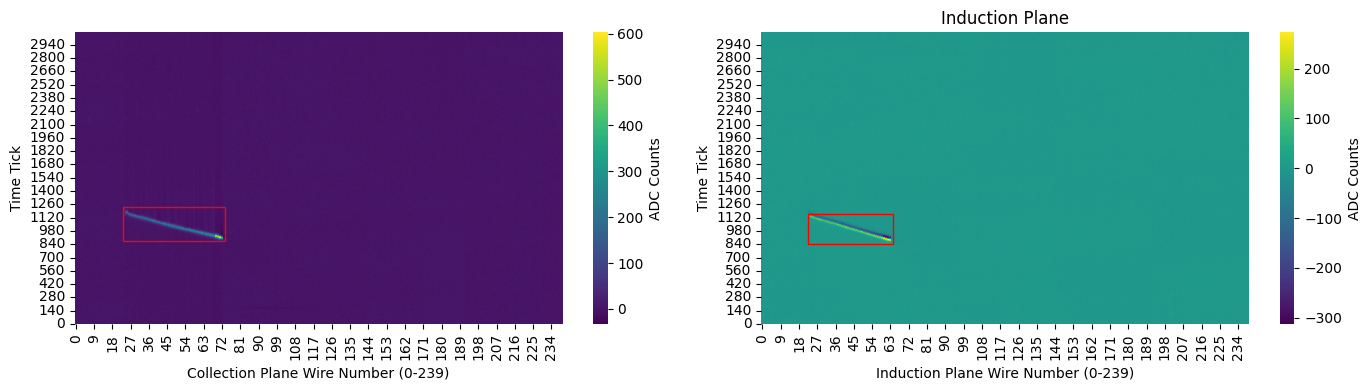

In [91]:
i = 0

row = g.iloc[i]
event = Event(g.iloc[i]['file_path'], index=g.iloc[i]['event_index'], plot=False)

c = event.collection
a = event.induction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
# ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
ax1.invert_yaxis()

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax1.add_patch(rect)

sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

row = g.iloc[i+1]

start_wire = row['bbox_min_row'] 
start_time = row['bbox_min_col']
width = row['height']
height = row['width']

rect = Rectangle((start_wire, start_time), 
                    width, height, 
                    linewidth=1, 
                    edgecolor='red', 
                    facecolor='none')
ax2.add_patch(rect)

plt.tight_layout()  
# plt.savefig(f'/Users/user/data/research/proton-deuteron/findingdeuterons/{i}.png', 
#             dpi=150, bbox_inches='tight')  
# plt.close()  

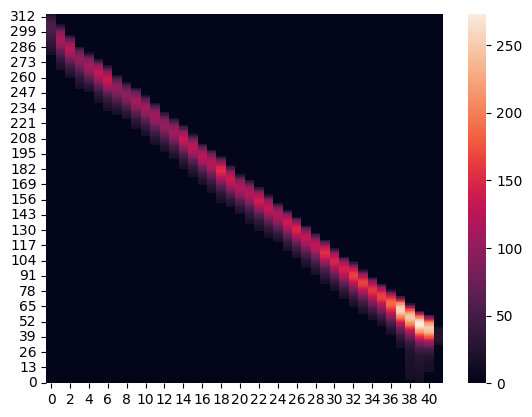

In [92]:
sns.heatmap(row['image_intensity'].T)
plt.gca().invert_yaxis()

In [94]:
event_data = g.copy()


csv_data = pd.DataFrame({
    'run': [event_data['run'].iloc[0]],
    'subrun': [event_data['subrun'].iloc[0]],
    'event': [event_data['event'].iloc[0]],
    'c_w_i': [event_data.loc[event_data['plane'] == 'collection', 'bbox_min_row'].values[0]],
    'c_w_f': [event_data.loc[event_data['plane'] == 'collection', 'bbox_max_row'].values[0]],
    'c_t_i': [event_data.loc[event_data['plane'] == 'collection', 'bbox_min_col'].values[0]],
    'c_t_f': [event_data.loc[event_data['plane'] == 'collection', 'bbox_max_col'].values[0]],
    'i_w_i': [event_data.loc[event_data['plane'] == 'induction', 'bbox_min_row'].values[0]],
    'i_w_f': [event_data.loc[event_data['plane'] == 'induction', 'bbox_max_row'].values[0]],
    'i_t_i': [event_data.loc[event_data['plane'] == 'induction', 'bbox_min_col'].values[0]],
    'i_t_f': [event_data.loc[event_data['plane'] == 'induction', 'bbox_max_col'].values[0]]
})

# Save to a CSV file
csv_data.to_csv('/Users/user/data/research/proton-deuteron/bboxReco.csv', index=False)
print("CSV file created successfully.")

CSV file created successfully.
